In [45]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
import cv2
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle

# Snake env

In [46]:
class SnakeEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 10}

    def __init__(self, grid_size=10):
        super().__init__()
        self.grid_size = grid_size
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0, high=2,
                                            shape=(grid_size, grid_size), dtype=np.uint8)

        self.reset()

    def reset(self, seed=None, options=None):
        self.snake = [(self.grid_size // 2, self.grid_size // 2)]
        self.direction = random.choice([0, 1, 2, 3])
        self.done = False
        self.score = 0
        self._place_food()
        return self._get_obs(), {}

    def _place_food(self):
        empty = [(i, j) for i in range(self.grid_size)
                 for j in range(self.grid_size) if (i, j) not in self.snake]
        self.food = random.choice(empty)

    def _get_obs(self):
        obs = np.zeros((self.grid_size, self.grid_size), dtype=np.uint8)
        for y, x in self.snake:
            obs[y][x] = 1
        fy, fx = self.food
        obs[fy][fx] = 2
        return obs

    def step(self, action):
        if abs(action - self.direction) == 2:
            action = self.direction
        self.direction = action
        head_y, head_x = self.snake[0]
        if action == 0:
            head_y -= 1
        elif action == 1:
            head_x += 1
        elif action == 2:
            head_y += 1
        elif action == 3:
            head_x -= 1
        new_head = (head_y, head_x)

        if (not 0 <= head_y < self.grid_size or
                not 0 <= head_x < self.grid_size or
                new_head in self.snake):
            self.done = True
            return self._get_obs(), -10, self.done, False, {}

        self.snake.insert(0, new_head)
        if new_head == self.food:
            self.score += 1
            self._place_food()
            reward = 10
        else:
            self.snake.pop()
            reward = -0.1

        return self._get_obs(), reward, self.done, False, {}

    def render(self):
        cell_size = 20
        img = np.zeros((self.grid_size * cell_size, self.grid_size * cell_size, 3), dtype=np.uint8)
    
        for y in range(self.grid_size):
            for x in range(self.grid_size):
                top_left = (x * cell_size, y * cell_size)
                bottom_right = ((x + 1) * cell_size - 1, (y + 1) * cell_size - 1)
                if (y, x) == self.snake[0]:
                    color = (0, 255, 0) 
                elif (y, x) in self.snake:
                    color = (0, 155, 0)
                elif (y, x) == self.food:
                    color = (255, 0, 255)
                else:
                    color = (50, 50, 50)
                cv2.rectangle(img, top_left, bottom_right, color, -1)
    
        return img

    def close(self):
        pass


# Q learning


Episode 0, reward: -17.70, epsilon: 0.995
Episode 100, reward: -3.40, epsilon: 0.603
Episode 200, reward: 14.60, epsilon: 0.365
Episode 300, reward: 20.60, epsilon: 0.221
Episode 400, reward: 76.40, epsilon: 0.134
Episode 500, reward: 86.90, epsilon: 0.081
Episode 600, reward: 74.70, epsilon: 0.050
Episode 700, reward: 41.40, epsilon: 0.050
Episode 800, reward: 196.80, epsilon: 0.050
Episode 900, reward: 68.40, epsilon: 0.050
Episode 1000, reward: 54.30, epsilon: 0.050
Episode 1100, reward: 184.80, epsilon: 0.050
Episode 1200, reward: 133.70, epsilon: 0.050
Episode 1300, reward: 166.80, epsilon: 0.050
Episode 1400, reward: 40.90, epsilon: 0.050
Episode 1500, reward: 144.10, epsilon: 0.050
Episode 1600, reward: 153.30, epsilon: 0.050
Episode 1700, reward: 20.00, epsilon: 0.050
Episode 1800, reward: 210.90, epsilon: 0.050
Episode 1900, reward: 182.30, epsilon: 0.050
Episode 2000, reward: 153.30, epsilon: 0.050
Episode 2100, reward: 16.30, epsilon: 0.050
Episode 2200, reward: 23.70, epsil

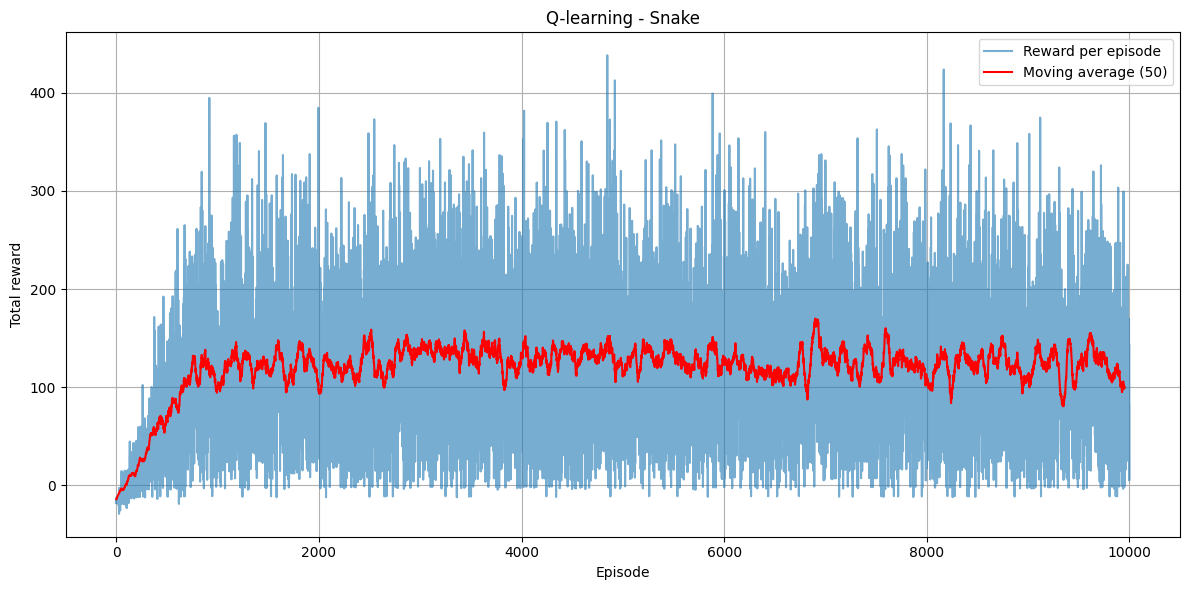

In [47]:
env = SnakeEnv(grid_size=20)

ACTIONS = [0, 1, 2, 3]
q_table = defaultdict(lambda: [0.0 for _ in ACTIONS])

alpha = 0.1
gamma = 0.9
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.05
episodes = 10000

all_rewards = []

def get_state(env):
    head_y, head_x = env.snake[0]
    food_y, food_x = env.food
    dir = env.direction

    food_dir = (
        int(food_y < head_y),
        int(food_y > head_y),
        int(food_x < head_x),
        int(food_x > head_x),
    )

    def danger(y, x):
        return (
            x < 0 or x >= env.grid_size or
            y < 0 or y >= env.grid_size or
            (y, x) in env.snake
        )

    front = left = right = 0
    if dir == 0:
        front = danger(head_y - 1, head_x)
        left = danger(head_y, head_x - 1)
        right = danger(head_y, head_x + 1)
    elif dir == 1:
        front = danger(head_y, head_x + 1)
        left = danger(head_y - 1, head_x)
        right = danger(head_y + 1, head_x)
    elif dir == 2:
        front = danger(head_y + 1, head_x)
        left = danger(head_y, head_x + 1)
        right = danger(head_y, head_x - 1)
    elif dir == 3:
        front = danger(head_y, head_x - 1)
        left = danger(head_y + 1, head_x)
        right = danger(head_y - 1, head_x)

    return (
        front, left, right,
        food_dir[0], food_dir[1], food_dir[2], food_dir[3],
        dir
    )

for ep in range(episodes):
    obs, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        state = get_state(env)

        if random.random() < epsilon:
            action = random.choice(ACTIONS)
        else:
            action = np.argmax(q_table[state])

        obs, reward, done, _, _ = env.step(action)
        next_state = get_state(env)

        old_value = q_table[state][action]
        next_max = max(q_table[next_state])
        new_value = old_value + alpha * (reward + gamma * next_max - old_value)
        q_table[state][action] = new_value

        total_reward += reward

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    all_rewards.append(total_reward)

    if ep % 100 == 0:
        print(f"Episode {ep}, reward: {total_reward:.2f}, epsilon: {epsilon:.3f}")

with open("q_table_snake.pkl", "wb") as f:
    pickle.dump(all_rewards, f)

plt.figure(figsize=(12, 6))
plt.plot(all_rewards, label="Reward per episode", alpha=0.6)
plt.plot(
    np.convolve(all_rewards, np.ones(50)/50, mode='valid'),
    label="Moving average (50)", color="red"
)
plt.title("Q-learning - Snake")
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("learning_curve_snake.png")
plt.show()


# Snake game

In [49]:
obs, _ = env.reset()
terminated = False
truncated = False
total_reward = 0

while not (terminated or truncated):
    state = get_state(env)
    action = np.argmax(q_table[state])
    obs, reward, terminated, truncated, _ = env.step(action)
    total_reward += reward

    frame = env.render()
    cv2.imshow("Snake", cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    if cv2.waitKey(10) & 0xFF == 27:
        break
    if cv2.getWindowProperty('Snake', cv2.WND_PROP_VISIBLE) < 1:
        break

cv2.destroyAllWindows()
print("Wynik końcowy:", total_reward)

Wynik końcowy: 391.39999999999577
